# Clustering and Topic Modeling

In this article we will explore how to cluster and topic model text data using language models. We will be playing with the `ArXiv` NLP dataset, which contains a collection of abstracts from the famous ArXiv website.

> This is a good use case since reasearch papers are often clustered and topic modeled by funders, researchers, and other stakeholders to better understand the research landscape and identify trends 😎


In [ ]:
!pip install bertopic datasets groq datamapplot

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.5/168.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 18.3 MB/s eta 0:00:00
  Created wheel for Pyqtree: filename=Pyqtree-1.0.0-py3-none-any.whl size=5969 sha256=cba2fd2305e2588249834cf7df6fbea78a82716b18ecab9b993cfbc47a0851b7
  Stored in directory: /root/.cache/pip/wheels/86/02/24/506ac193949f48c8bec599b613d722bd64a83063a1

Load the ArXiv dataset from hf hub `maartengr/arxiv_nlp`

In [ ]:
# Load data from huggingface
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Traditional pipeline for text clustering

Text clustering is a powerful technique for uncovering both familiar and hidden patterns inside text data. It provides an intuitive grasp of tasks like classification while revealing their underlying complexity, making it far more valuable than a simple exploratory data analysis tool 🥸

While numerous text clustering approaches exists; from graph-based neural architectures to centroid-driven clustering methods widely adopted pipeline has emerged, consisting of **three key stages**

**1. Transform input documents into numerical embeddings using an embedding model.**

**2. Compress the embedding dimensions through a dimensionality reduction algorithm.**

**3. Identify clusters of semantically related documents using a clustering model.**



### Embedding Documents

As you may know from now; embeddings are numerical representations of text that attempt to capture its meaning.

**Choosing embedding models optimized for semantic similarity tasks is especially important for clustering as we attempt to find groups of semantically similar documents. Fortunately, most embedding models at the time of writing focus on just that, semantic similarity 😎**


You can choose your model inside the [embedding benchmark](https://huggingface.co/spaces/mteb/leaderboard)

> Here we will chose a tiny model such as `thenlper/gte-small` for fitting our hardware

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('thenlper/gte-small')
model.max_seq_length = 64   #im reducing the size because my computer cannot handle the 512 dimensions

embeddings = model.encode(
    abstracts,
    batch_size=64,
    show_progress_bar=True
)


Batches:   0%|          | 0/703 [00:00<?, ?it/s]

In [18]:
# dimensions of the embeddings
embeddings.shape

(44949, 384)

### Reducing the Dimensionality of Embeddings


Prior to clustering embeddings, we must address their high-dimensional nature. Higher dimensions lead to exponential increases in potential values across each dimension, making it progressively harder to explore all possible subspaces.

High-dimensional data poses significant challenges for most clustering algorithms, as identifying meaningful groupings becomes increasingly difficult 🤯.

Dimensionality reduction offers a solution to this problem **the idea is pretty straigh forward : compresses the dimensional space, enabling data representation with fewer dimensions while maintaining its essential characteristics.**

> ⚠️ Dimensionality reduction techniques, however, are not flawless. They do not perfectly capture high-dimensional data in a lower-dimensional representation. **Information will always be lost with this procedure. There is a balance between reducing dimensionality and keeping as much information as possible** ⚠️


We will work with the [`UMAP` model](https://huggingface.co/papers/1802.03426) for this reduction.

The `n_components` parameter determines the target dimensionality of the reduced space—in this case, 5 dimensions. Typically, selecting between 5 and 10 dimensions effectively preserves the global structure of a high dimensional dataset.

The `min_dist` parameter controls the minimum spacing between embedded points. Setting it to 0 tends to produce more compact, well defined clusters. We specify 'cosine' as the metric since Euclidean-based approaches struggle with high-dimensional datasets.

It's important to note that while setting a random_state in UMAP ensures reproducible results across different sessions, it disables parallel processing, which can significantly increase training time.

In [19]:
from umap import UMAP

# reduce the input embeddings from 384 dimenions to 5 dimenions
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

## Cluster the Reduced Embeddings

With dimensionally-reduced embeddings in hand, we can now identify clusters of related documents. We'll use **HDBSCAN** (Hierarchical Density-Based Spatial Clustering), which automatically determines the number of clusters and handles noise effectively.

The `min_cluster_size` parameter sets the minimum number of documents required to form a cluster. Documents that don't fit into any cluster are labeled as outliers (-1).

> If you are not familiar with DBSCAN, you can check out the article on my website [here](https://courses.dallard.tech/ml/notebooks/DBSCAN/) or if you only have 30sec go check the interactive visualization [here](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/).

In [20]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# How many clusters did we generate?
len(set(clusters))

178

## Inspecting the Clusters

Now that we have our clusters, (155 for instance) let's examine what they contain. We can look at individual documents within a cluster to understand what topics or themes the clustering algorithm has identified 👀

In [ ]:
import numpy as np

# inspect the first three documents in cluster 0:
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(list(abstracts)[index][:300] + "... \n")

  Sarcasm is considered one of the most difficult problem in sentiment
analysis. In our ob-servation on Indonesian social media, for cer-tain topics,
people tend to criticize something using sarcasm. Here, we proposed two
additional features to detect sarcasm after a common sentiment analysis is
con... 

  Automatic sarcasm detection is the task of predicting sarcasm in text. This
is a crucial step to sentiment analysis, considering prevalence and challenges
of sarcasm in sentiment-bearing text. Beginning with an approach that used
speech-based features, sarcasm detection has witnessed great interes... 

  We introduce a deep neural network for automated sarcasm detection. Recent
work has emphasized the need for models to capitalize on contextual features,
beyond lexical and syntactic cues present in utterances. For example, different
speakers will tend to employ sarcasm regarding different subjects... 



Next, we reduce our embeddings to 2-dimensions so that we can plot them and get a rough understanding of the generated clusters.

In [ ]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Cluster visualization

Now let's visualize the clusters in 2D space using matplotlib (more convinient than represents 155 dimensions 😅).

Outliers are displayed in grey, while clusters are colored distinctly to highlight the grouping structure.

> 🤔 How can we decrease the number of grey points?


(np.float64(-8.935569763183594),
 np.float64(10.320304870605469),
 np.float64(-6.888222479820252),
 np.float64(12.660802149772644))

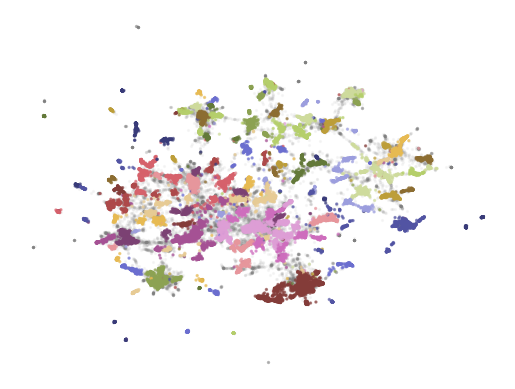

In [ ]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
# plt.savefig("matplotlib.png", dpi=300)  # Uncomment to save the graph as a .png

## From clustering to Topic Modeling

**While clustering groups documents together, topic modeling goes a step further by extracting meaningful keywords that describe each cluster.**

> This transforms numeric clusters into interpretable topics that can be understood by humans 🧠


We will use [BERTopic](https://github.com/MaartenGr/BERTopic) to perform our topic modeling task here. BERTopic combines the three-stage clustering pipeline with an additional layer: topic representation. It uses class-based TF-IDF (c-TF-IDF) to extract the most important keywords for each cluster, creating interpretable topic descriptions.

> The framework is modular, allowing you to plug in your own embedding, dimensionality reduction, and clustering models

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-12-03 15:06:10,240 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-03 15:08:45,807 - BERTopic - Dimensionality - Completed ✓
2025-12-03 15:08:45,811 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-03 15:09:02,550 - BERTopic - Cluster - Completed ✓
2025-12-03 15:09:02,590 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-03 15:09:17,881 - BERTopic - Representation - Completed ✓


Now, let's start exploring the topics that we got by running the code above.

In [ ]:
topic_model.get_topic_info()

Topic  Count                                            Name  \
0       -1  15125                                -1_the_of_and_to   
1        0   1226            0_dialogue_dialog_response_responses   
2        1    938       1_transformer_attention_transformers_bert   
3        2    843               2_hate_offensive_speech_detection   
4        3    733                    3_asr_speech_recognition_wer   
..     ...    ...                                             ...   
173    172     54           172_domain_adaptation_nmt_translation   
174    173     53  173_cognate_phylogenetic_cognates_phonological   
175    174     53                     174_job_resume_skill_skills   
176    175     51                    175_typing_entity_type_types   
177    176     50              176_table_tabular_tables_reasoning   

                                        Representation  \
0        [the, of, and, to, in, we, for, that, on, is]   
1    [dialogue, dialog, response, responses, orient...   
2    [transformer, attention, transformers, bert, t...   
3    [hate, offensive, speech, detection, social, m...   
4    [asr, speech, recognition, wer, acoustic, end,...   
..                                                 ...   
173  [domain, adaptation, nmt, translation, domains...   
174  [cognate, phylogenetic, cognates, phonological...   
175  [job, resume, skill, skills, resumes, market, ...   
176  [typing, entity, type, types, grained, fet, me...   
177  [table, tabular, tables, reasoning, column, da...   

                                   Representative_Docs  
0    [  While instruction-tuned Large Language Mode...  
1    [  End-to-end training of neural networks is a...  
2    [  Transformer-based models show their effecti...  
3    [  A key challenge for automatic hate-speech d...  
4    [  All-neural, end-to-end ASR systems gained r...  
..                                                 ...  
173  [  State-of-the-art neural machine translation...  
174  [  In traditional studies on language evolutio...  
175  [  A reliable resume-job matching system helps...  
176  [  For the task of fine-grained entity typing ...  
177  [  Tables are an important form of structured ...  

[178 rows x 5 columns]

Hundreds of topics were generated using the default model! To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the `get_topic()` function:

In [ ]:
topic_model.get_topic(0)

[('dialogue', np.float64(0.026543191644726308)),
 ('dialog', np.float64(0.014732519831382946)),
 ('response', np.float64(0.01453782919460124)),
 ('responses', np.float64(0.012520011148060402)),
 ('oriented', np.float64(0.010625380135372717)),
 ('conversation', np.float64(0.009311016548290446)),
 ('conversational', np.float64(0.008297249034410696)),
 ('systems', np.float64(0.007949455366627499)),
 ('dialogues', np.float64(0.0074662229852930926)),
 ('tod', np.float64(0.007322047725234333))]

We can use the `find_topics()` function to search for specific topics based on a search term. Let’s search for a topic about topic modeling:

In [ ]:
topic_model.find_topics("topic modeling")

([27, 115, -1, 152, 40],
 [np.float32(0.96187687),
  np.float32(0.9247246),
  np.float32(0.91518205),
  np.float32(0.9053543),
  np.float32(0.9052311)])

It returns that topic 22 has a relatively high similarity (0.95) with our search term. If we then inspect the topic, we can see that it is indeed a topic about topic modeling:

In [ ]:
topic_model.get_topic(22)

[('explanations', np.float64(0.02862592779173227)),
 ('explanation', np.float64(0.017970009892371856)),
 ('rationales', np.float64(0.016651097395303772)),
 ('rationale', np.float64(0.011997555272273384)),
 ('interpretability', np.float64(0.011683834763713463)),
 ('predictions', np.float64(0.00913266481647798)),
 ('methods', np.float64(0.008419533792951947)),
 ('nlp', np.float64(0.0077013800985615945)),
 ('model', np.float64(0.007357807691301977)),
 ('faithfulness', np.float64(0.007296203135929757))]

That seems like a topic that is, in part, characterized by the classic LDA technique. Let's see if the BERTopic paper was also assigned to topic 22:

In [ ]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

27

**Interactive visualization**

The cool tool from BERTopic is the interactive visualization of documents across topics called `visualize_documents()`. This interactive visualization shows how documents are distributed across topics in 2D space.

> Each point represents a document, colored by its assigned topic

In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_documents(
    list(titles),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# Update fonts of legend for easier visualization
fig.update_layout(font=dict(size=16))

In [ ]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

## **Representation Models**

In these examples that follow, we will update our topic representations **after** having trained our model. This allows for quick iteration. If, however, you want to use a representation model at the start of training, you will need to run it as follows:

```python
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# Create your representation model
representation_model = KeyBERTInspired()

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model)
```

To use the representation models, we are first going to duplicate our topic model such that easily show the differences between a model with and without representation model.

In [3]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.0 MB/s eta 0:00:00


In [4]:
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# Create your representation model
representation_model = KeyBERTInspired()

# Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model)

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [10]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [11]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

### KeyBERTInspired

This representation model leverages embeddings to find keywords most similar to the topic's overall semantic meaning, resulting in more coherent and representative topic descriptions.

In [13]:
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [15]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

NameError: name 'umap_model' is not defined

In [ ]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

### Maximal Marginal Relevance

MMR balances relevance and diversity when selecting keywords. The `diversity` parameter (0-1) controls this trade-off: higher values produce more diverse keywords, while lower values prioritize relevance.

In [ ]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0  dialogues | dialogue | conversational | conver...   
1      1      transformer | encoder | nlp | task | language   
2      2    hate | hateful | language | twitter | offensive   
3      3  phonetic | transcriptions | pronunciation | as...   
4      4  embedding | embeddings | word2vec | word | rep...   

                                             Updated  
0  response | oriented | conversational | systems...  
1     transformer | attention | bert | self | layers  
2    offensive | social | toxic | hateful | comments  
3             asr | training | ctc | systems | audio  
4  embeddings | vector | word2vec | tasks | simil...

## Text Generation


Instead of using keywords, we can leverage some Large Language Models (LLMs) to generate natural language descriptions of topics. This produces more readable and contextually rich topic labels.

### Flan-T5

For this we will use Flan-T5, a small instruction-tuned model that can generate topic descriptions based on a custom prompt. We provide representative documents and keywords as context, and the model generates a concise topic label.    

> 🤔 What is an instruction-tuned model ?   








In [ ]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

Device set to use cuda:0
100%|██████████| 155/155 [00:55<00:00,  2.81it/s]


Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2      hate | offensive | speech | detection | toxic   
3      3  summarization | summaries | summary | abstract...   
4      4      gender | bias | biases | debiasing | fairness   

                                             Updated  
0  Question answering is one of the most importan...  
1     Speech-to-speech comparison metric |  |  |  |   
2                           Science/Tech |  |  |  |   
3                 Document summarization |  |  |  |   
4  Gender bias in artificial intelligence and nat...

In [ ]:
! export GROQ_API_KEY="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"

### Groq - OpenAI alternative

Like in our previous example, we will use Groq to generate our topic labels. It is a great alternative to OpenAI, cheaper and faster.

> Do not forget to set your API key as an environment variable and to not expose it to the public please !

In [ ]:
! pip install groq

#### Activity

Let's now generate our topic labels using Groq. You will do it this time 🤓

Your task is to write a function that uses the Groq API to generate better, more human-readable labels for topics discovered by BERTopic. Instead of having generic "Topic 0", "Topic 1" labels, your function will create meaningful names like "Machine Learning Applications" or "Climate Change Research."

The function should look like this :

```python

def update_topics_with_groq(topic_model, documents, model="meta-llama/llama-4-scout-17b-16e-instruct"):
    # Your code here
    pass
```

# Function Assignment: `update_topics_with_groq`

## Overview
Your task is to write a function that uses the Groq API to generate better, more human-readable labels for topics discovered by BERTopic. Instead of having generic "Topic 0", "Topic 1" labels, your function will create meaningful names like "Machine Learning Applications" or "Climate Change Research."

## Function Signature
```python
def update_topics_with_groq(topic_model, documents, model="meta-llama/llama-4-scout-17b-16e-instruct"):
    # Your code here
```

## What Your Function Must Do

### Step 1: Extract Current Topics
- Retrieve all topics from the `topic_model` using the `.get_topics()` method
- Create an empty dictionary called `updated_labels` to store your new topic names

### Step 2: Create Your Prompt Template

Design a prompt string that includes:

- A section showing representative documents from the topic
- A section showing the top keywords describing the topic
- Clear instructions asking the LLM to extract a short, concise topic label
- Format instruction: `topic: <short topic label>`

### Step 3: Loop Through Each Topic

For each topic in your topics dictionary:

- **Skip the outlier topic** (topic_id == -1)
- Get the top 5 representative documents for this topic using `.get_representative_docs(topic_id)`
- Join these documents with newlines for readability
- Extract the top 10 keywords from the topic (they come as word-score pairs, you only need the words)
- Format the keywords as a comma-separated string

### Step 4: Call the Groq API

For each topic, make an API call with the following requirements:

Implement retry logic (maximum 3 attempts):

- Use the `client.chat.completions.create()` method
- Set up two messages:
  - **System message**: Tell the AI it's a helpful assistant that creates concise topic labels
  - **User message**: Your formatted prompt with documents and keywords filled in
- Use `temperature=0` for consistent results
- Set `max_tokens=500` as the limit

**Handle the response**:

- Extract the text content from `response.choices[0].message.content`
- Strip whitespace
- Remove the "topic: " prefix if the LLM included it (case-insensitive check)
- Store the cleaned label in your `updated_labels` dictionary with the topic_id as key

### Step 5: Error Handling & Rate Limiting

- Add a 0.5 to 1 second delay after each successful API call to respect rate limits with the `random` module
- If an API call fails:
  - Retry up to 3 times
  - Use **exponential backoff**: wait 2^attempt seconds (1s, 2s, 4s)
  - Print retry messages to inform the user
  - If all retries fail, use a fallback label: `f"Topic {topic_id}"`

### Step 6: Update and Return

- Apply all your new labels to the topic model using `.set_topic_labels(updated_labels)`
- Return the updated topic_model



You should see an output like the dataframe below


In [ ]:
from groq import Groq
import os
from dotenv import load_dotenv
import time

load_dotenv()
import time
import random
from groq import Groq


def update_topics_with_groq(topic_model, documents, model="meta-llama/llama-4-scout-17b-16e-instruct"):
    """
    Updates topic labels in a BERTopic model using Groq API to generate
    more human-readable and meaningful topic names.


    """
    # Step 1: Extract Current Topics
    topics = topic_model.get_topics()
    updated_labels = {}


    client = Groq()

    # Step 2: Create Your Prompt Template
    prompt_template = """You are analyzing a topic discovered in a document collection. Below are representative documents and keywords for this topic.

Representative Documents:
{documents}

Top Keywords:
{keywords}

Please analyze the content and create a short, concise topic label (2-5 words) that best describes this topic.

Format your response as: topic: <short topic label>"""

    # Step 3: Loop Through Each Topic
    for topic_id in topics.keys():
        # Skip the outlier topic
        if topic_id == -1:
            continue

        # Get the top 5 representative documents for this topic
        try:
            representative_docs = topic_model.get_representative_docs(topic_id)
            # Take top 5 if more are available
            if len(representative_docs) >5:
                representative_docs = representative_docs[:5]
            # Join documents with newlines for readability
            documents_text = "\n".join([f"- {doc}" for doc in representative_docs])
        except Exception as e:
            print(f"Warning: Could not get representative docs for topic {topic_id}: {e}")
            documents_text = "No representative documents available."

        # Extract the top 10 keywords from the topic
        topic_keywords = topics[topic_id]

        keyword_words = [word for word, score in topic_keywords[:10]]

        keywords_text = ", ".join(keyword_words)

        # Format the prompt with documents and keywords
        prompt = prompt_template.format(
            documents=documents_text,
            keywords=keywords_text
        )

        # Step 4: Call the Groq API with retry logic
        max_attempts = 3
        label = None

        for attempt in range(max_attempts):
            try:
                # Make API call
                response = client.chat.completions.create(
                    model=model,
                    messages=[
                        {
                            "role": "system",
                            "content": "You are a helpful assistant that creates concise, descriptive topic labels for document collections."
                        },
                        {
                            "role": "user",
                            "content": prompt
                        }
                    ],
                    temperature=0,
                    max_tokens=500
                )

                # Extract the text content
                response_text = response.choices[0].message.content.strip()

                # Remove the "topic: " prefix if the LLM included it (case-insensitive)
                response_lower = response_text.lower()
                if response_lower.startswith("topic:"):
                    # Find the colon and take everything after it
                    colon_index = response_text.find(":")
                    label = response_text[colon_index + 1:].strip()
                else:
                    label = response_text

                # Success - break out of retry loop
                break

            except Exception as e:
                if attempt < max_attempts - 1:
                    # Calculate exponential backoff: wait 2^attempt seconds
                    wait_time = 2 ** attempt
                    print(f"API call failed for topic {topic_id} (attempt {attempt + 1}/{max_attempts}): {e}")
                    print(f"Retrying in {wait_time} seconds...")
                    time.sleep(wait_time)
                else:
                    # All retries failed, use fallback label
                    print(f"All retries failed for topic {topic_id}. Using fallback label.")
                    label = f"Topic {topic_id}"

        # Store the cleaned label
        updated_labels[topic_id] = label

        # Step 5: Rate Limiting - Add delay after each successful API call
        if label and label != f"Topic {topic_id}":  # Only delay if we got a real label
            delay = random.uniform(0.5, 1.0)
            time.sleep(delay)

    # Step 6: Update and Return
    topic_model.set_topic_labels(updated_labels)
    return topic_model



     Topic  Count                                               Name  \
0       -1  14830           -1_Natural language sentence matching___   
1        0   2203  0_Question answering is one of the most import...   
2        1   1972            1_Speech-to-speech comparison metric___   
3        2    859                                  2_Science/Tech___   
4        3    848                        3_Document summarization___   
..     ...    ...                                                ...   
150    149     53                                 149_Psychiatric___   
151    150     53                                 150_Code-mixing___   
152    151     53                                151_Science/Tech___   
153    152     50                           152_Long-context LLMs___   
154    153     50                                153_Science/Tech___   

                                            CustomName  \
0             -1_Natural language sentence matching___   
1    Based on the p

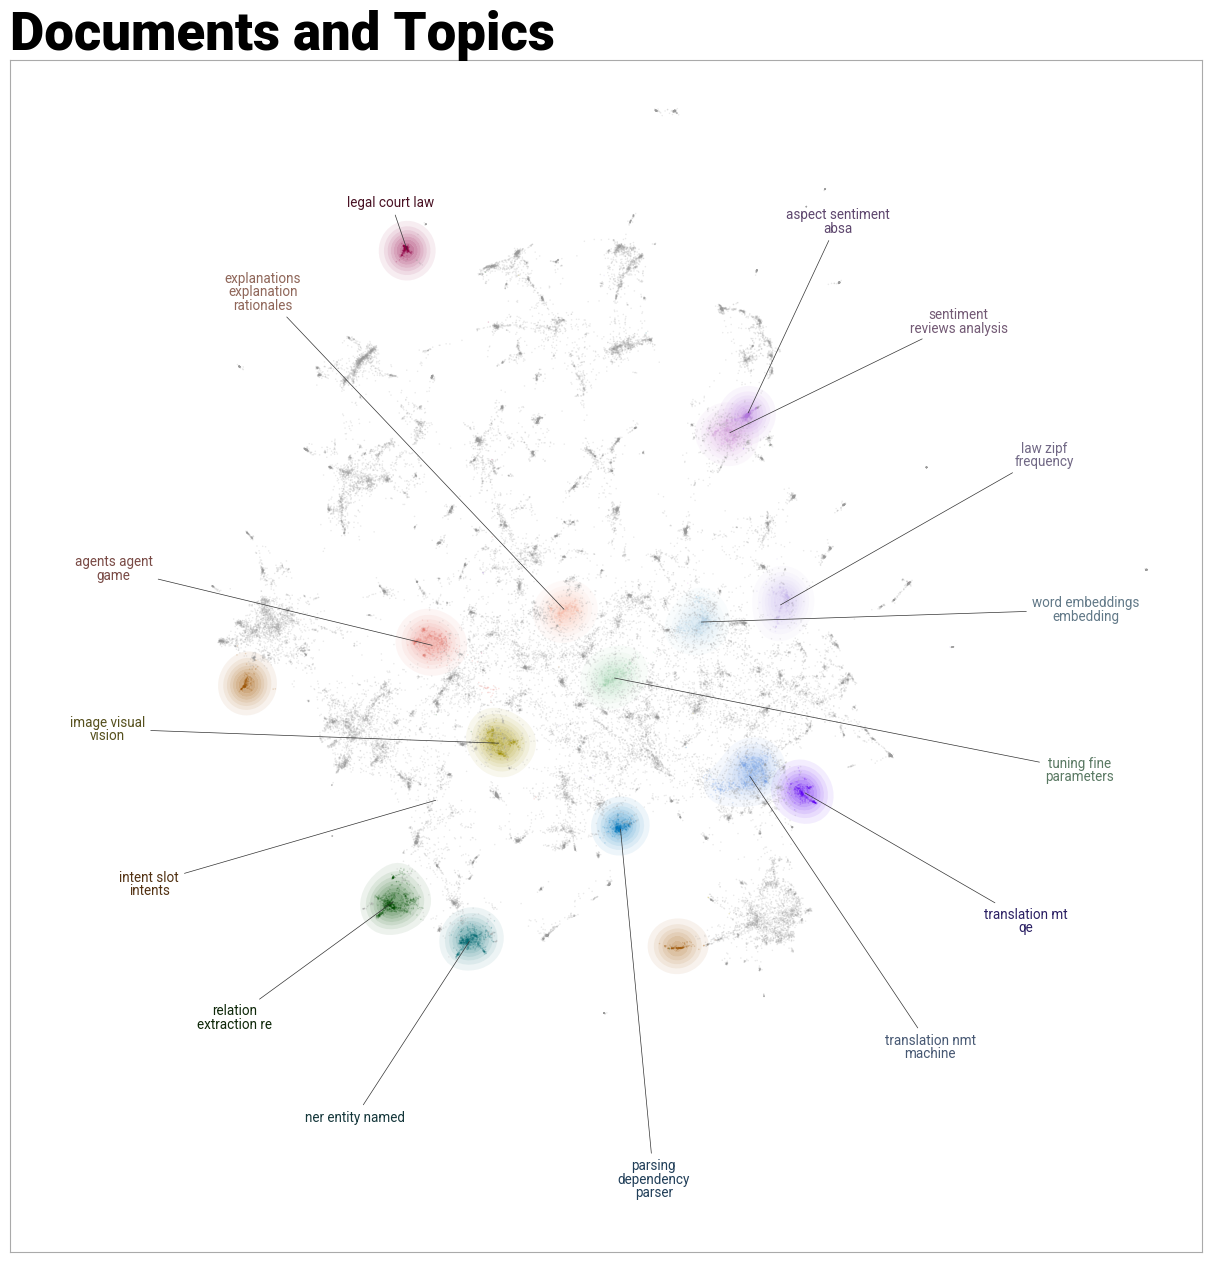

In [ ]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    topics=list(range(5,20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    height=1200,
)
plt.savefig("datamapplot.png")


## The classico classic : word cloud

Make sure to pip install `wordcloud` first in order to run this code


First, we need to make sure that each topic is described by a bit more words than just 10 as that would make for a much more interesting wordcloud.

In [ ]:
topic_model.update_topics(abstracts, top_n_words=500)

2025-12-01 01:18:55,030 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


Then, we can run the following code to generate the wordcloud for our topic modeling task :

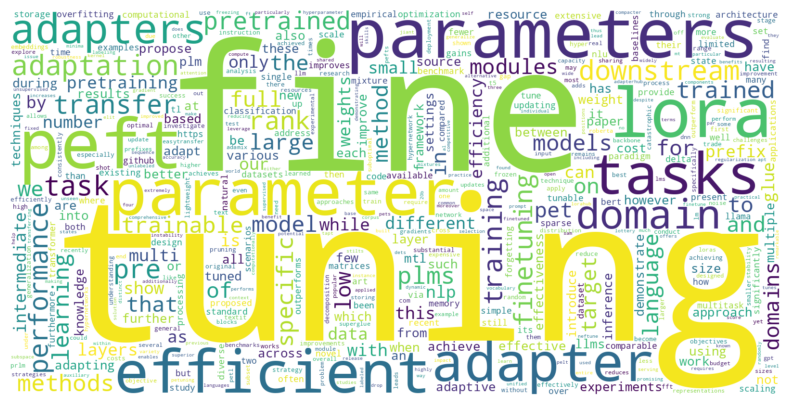

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    plt.figure(figsize=(10,5))
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000, width=1600, height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=17)